# 第9章 教師なし学習

## 9.1 2次元入力データ

/var/folders/2n/k04q38yx087g0pz_q6w7gfd40000gn/T/ipykernel_32971/556089637.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = \


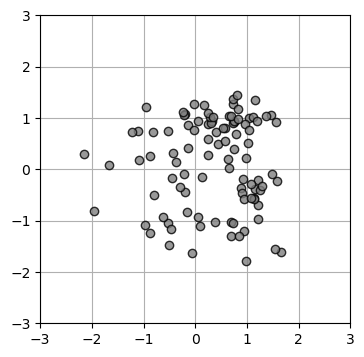

In [3]:
# リスト 9-1-(1)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# データ生成 ----------
np.random.seed(seed=1)  # 乱数を固定
N = 100                 # データの数
K = 3                   # ガウス分布の数
T = np.zeros((N, 3), dtype=np.uint8)  # 空のTを準備 100行3列の行列を作成し、すべての値が0
X = np.zeros((N, 2))                  # 空のXを準備 100行2列の行列を作成し、すべての値が0
X0_min, X0_max = -3, 3  # x0の範囲、表示用
X1_min, X1_max = -3, 3  # x1の範囲、表示用
prm_mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])  # 分布の中心
prm_sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])  # 分布の分散
prm_pi = np.array([0.4, 0.8, 1])  # 各分布への割合を決めるパラメータ
cols = ["cornflowerblue", "black", "white"]  # 結果表示用
# TはXを作るために決めるが、データにはしない
for n in range(N): # 0-n-99
    r = np.random.rand() # 0~1のランダムな数を生成
    for k in range(K): # 0-k-2
        if r < prm_pi[k]: # r < prm_pi[k]となるk(0-k-2)を使用し、 T[n, k] = 1とする。つまりTの各行に必ず１つ1が入る
            T[n, k] = 1
            break
    for k in range(2): # 0-k-1
        X[n, k] = \
            np.random.randn() * prm_sig[T[n, :] == 1, k] \
            + prm_mu[T[n, :] == 1, k]    # -1~1のランダムな数を生成、T[n, :] == 1 n行で1になっている列を求める

# データの図示 ----------
def show_data(x):
    plt.plot(
        x[:, 0], x[:, 1], "gray",
        marker="o", linestyle="None",
        markeredgecolor="black",
        markersize=6, alpha=0.8,
    )
    plt.grid()

# メイン ----------
plt.figure(figsize=(4, 4))
show_data(X)
plt.xlim(X0_min, X0_max) # -3~3
plt.ylim(X1_min, X1_max)
plt.show()
np.savez(
    "ch9_data.npz", X=X,
    X0_min=X0_min, X0_max=X0_max,
    X1_min=X1_min, X1_max=X1_max,
)

## 9.2 K-means法

### 9.2.1 K-means法の概要

### 9.2.2 Step0: 変数の準備と初期化

In [8]:
# リスト 9-1-(2)
# Mu と R の初期化 ----------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])                         # (A)　クラスターの中心ベクトル
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]  # (B)  クラス指示変数 : 列方向で結合 100行3列 1列目は１、2,3行目は0

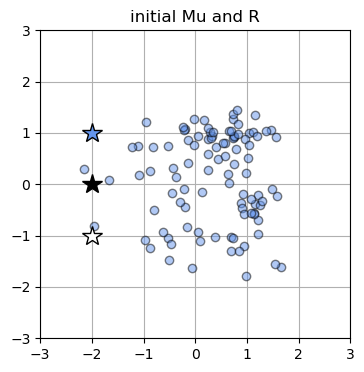

In [10]:
# リスト 9-1-(3)
# データの図示関数 ----------
def show_prm(x, r, mu, cols):
    K = r.shape[1] #行数:3
    for k in range(K): #0-k-2
        # 入力データxの描写(クラス指示変数rで色分け)
        plt.plot(
            x[r[:, k] == 1, 0], x[r[:, k] == 1, 1], cols[k], # rのk列目で1になっている行を探して、xの行数として使用する
            marker="o", linestyle="None", markeredgecolor="black",
            markersize=6, alpha=0.5,
        )
        # クラスターの中心ベクトルmuを「星マーク」で描写
        plt.plot(
            mu[k, 0], mu[k, 1], cols[k], # cols = ["cornflowerblue", "black", "white"] 
            marker="*", markeredgecolor="black",
            markersize=15, markeredgewidth=1,
        )
    plt.xlim(X0_min, X0_max) # -3~3
    plt.ylim(X1_min, X1_max)
    plt.grid()

# メイン ----------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, cols)
plt.title("initial Mu and R")
plt.show()

### 9.2.3 Step 1: Rの更新

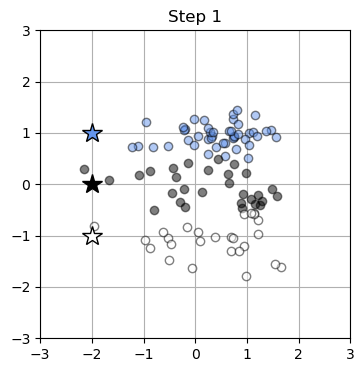

In [13]:
# リスト 9-1-(4)
# r を決める (Step 1) ----------
def step1_kmeans(x0, x1, mu):
    N = len(x0) # ex) N=100
    K = mu.shape[0] # 行数 ex) K=3
    r = np.zeros((N, K)) # 100行3列の行列、全ての値が0
    for n in range(N): # 0-n-99
        d = np.zeros(K) # 1行3列,全ての値が0
        # 式9-4で二乗距離を計算
        for k in range(K): # 0-k-2
            d[k] = (x0[n] - mu[k, 0]) ** 2 + (x1[n] - mu[k, 1]) ** 2  # (x0の各行 - 中心のx座標)^2 + (x1の各行 - 中心のy座標)^2
        r[n, np.argmin(d)] = 1  # 最も近いクラスターの所属にする
    return r

# メイン ----------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, cols)
plt.title("Step 1")
plt.show()

### 9.2.4 Step 2: $\mu$の更新

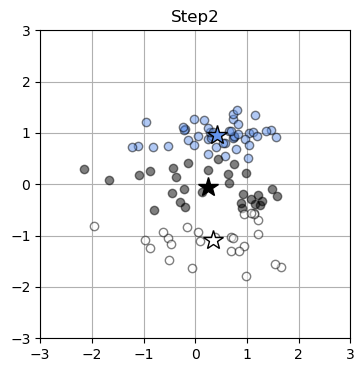

In [16]:
# リスト 9-1-(5)
# Mu を決める (Step 2) ----------
def step2_kmeans(x0, x1, r):
    K = r.shape[1] # 列数 (ex)K=3   
    mu = np.zeros((K, 2)) # 中心ベクトルの入れ物 3行2列
    # 式9-6の計算
    for k in range(K): # 0-k-2
        N_k = np.sum(r[:, k]) #各列の数字を合計する
        mu[k, 0] = np.sum(r[:, k] * x0) / N_k # rには1or0なので掛け算してもそのままか0になる
        mu[k, 1] = np.sum(r[:, k] * x1) / N_k
    return mu

# メイン ----------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R) # クラス指示変数 R:100行3列
show_prm(X, R, Mu, cols)
plt.title("Step2")
plt.show()

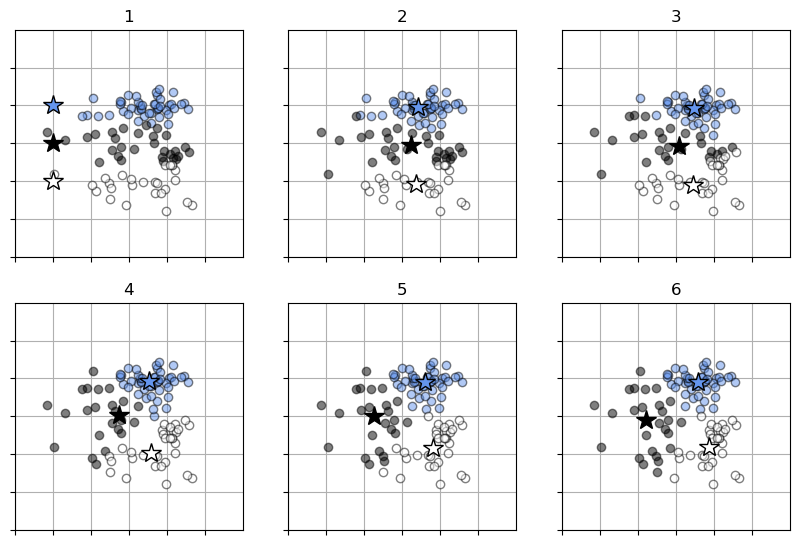

In [18]:
# リスト 9-1-(6)
plt.figure(figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) #中心ベクトル
max_it = 6  # 繰り返しの回数
for it in range(0, max_it): # 0-it-5
    # step1、R の更新
    R = step1_kmeans(X[:, 0], X[:, 1], Mu) #各クラスへの距離を測り、一番近いクラスに所属を変更する(データの数だけ行う)
    # 結果表示
    plt.subplot(2, 3, it + 1)
    show_prm(X, R, Mu, cols) #データと中心ベクトルの図示
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X0_min, X0_max), "") #　-3以上　x目盛り　-3以下
    plt.yticks(range(X1_min, X1_max), "") 
    # step2、Mu の更新
    Mu = step2_kmeans(X[:, 0], X[:, 1], R) #各クラスに所属するデータの中心に中心ベクトルを変更する
plt.show()

### 9.2.5 歪み尺度

In [21]:
# リスト 9-1-(7)
# 目的関数 ----------
def distortion_measure(x0, x1, r, mu):
    # 入力xは2次元とし、x0、x1で入力
    N = len(x0) #行数 (ex) N=100
    K = r.shape[1] #列数 (ex) K=3
    J = 0
    # 式9-9の計算
    for n in range(N): # 0-n-99
        for k in range(K): # 0-k-2
            J = J + r[n, k] * ((x0[n] - mu[k, 0]) ** 2 \
                + (x1[n] - mu[k, 1]) ** 2) #各クラスに所属するデータと中心ベクトルとの二乗距離の合計を計算、クラスが違うデータはr[n,k]=0になる
    return J

# テスト ----------
# Mu と R の初期化
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) #中心ベクトル
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] #クラス指示変数:100行3列 1列目は全て１
# 歪み尺度の計算
distortion = distortion_measure(X[:, 0], X[:, 1], R, Mu)
print(f"distortion measure = {distortion:.6f}") #小数第6位まで表示

distortion measure = 771.709117


distortion measure = [627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


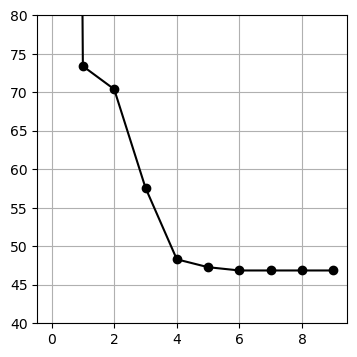

In [23]:
# リスト 9-1-(8)
# メイン ----------
# Mu と R の初期化
N = X.shape[0] #行数 (ex)N=100
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) #中心ベクトル
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] #クラス指示変数:100行3列で1行目は全て1が入っている
# k-means 法のステップごとで歪み尺度を計算
max_it = 10
it = 0
DM = np.zeros(max_it)  # 歪み尺度の計算結果を入れる配列を準備(10個の0)
for it in range(0, max_it): # 0-it-9                      # K-means 法 
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)                # step1:各クラスへの距離を測り、一番近いクラスに所属を変更する(データの数だけ行う)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu)  # 歪み尺度:各クラスに所属するデータと中心ベクトルとの二乗距離の合計を計算
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)                # step2:各クラスに所属するデータの中心に中心ベクトルを変更する
# 結果表示
print("distortion measure =", np.round(DM, 2))

# グラフ描画 ----------
plt.figure(figsize=(4, 4))
plt.plot(DM, "black", linestyle="-", marker="o")
plt.ylim(40, 80)
plt.grid()
plt.show()

## 9.3 混合ガウスモデル

### 9.3.1 確率的クラスタリング

### 9.3.2 混合ガウスモデル

In [28]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [30]:
# リスト 9-2-(1)
import numpy as np

data = np.load("ch9_data.npz")
X = data["X"] #100行2列 座標のデータが入っている
X0_min = data["X0_min"] # -3
X0_max = data["X0_max"] # 3
X1_min = data["X1_min"]
X1_max = data["X1_max"]

In [32]:
# リスト 9-2-(2)
# ガウス関数  ----------
def gauss(x, mu, sigma):  # リスト 4-6-(1) のNデータ対応バージョン mu:中心ベクトル, sigma:分散行列
    N = x.shape[0] # 行数 (ex) N=100
    y = np.zeros(N) # (ex) 100個の0
    inv_sigma = np.linalg.inv(sigma) #sigmaの逆行列を求める (ex)2行2列,    
    # 式4-142
    a = 1 / (2 * np.pi) * 1 / (np.linalg.det(sigma) ** (1 / 2)) #積分して1になるようにするようなaを設定, np.linalg.det(sigma):sigmaの行列式
    for n in range(N): # 0-n-99
        x_vec = np.array([x[n, 0], x[n, 1]]) #1次元の配列にする(座標のセットを作る)
        # 式4-138
        y[n] = a * np.exp(
            (-1 / 2) * (x_vec - mu).T @ inv_sigma @ (x_vec - mu)) #2次元ガウス関数の式
    return y

In [34]:
# リスト 9-2-(3)
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma)) # 入力したデータ数が３だから出力も３つ

[0.15915494 0.05854983 0.00291502]


In [36]:
# リスト  9-2-(4)
# 混合ガウスモデル ----------
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape #(ex) N=100, D=3
    K = len(pi) #混合係数:各ガウス分布の大きさの比率を表す  (ex) K=2
    p = np.zeros(N) #一次元配列で100個の0
    # 式9-14の計算
    for k in range(K): #0-k-1
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :]) # mu, sigmaが複数あるので行別に処理
    return p

In [38]:
# リスト 9-2-(5)
# テスト ----------2つのガウス分布を組み合わせた混合ガウスモデル
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [40]:
# リスト  9-2-(6)
%matplotlib inline
import matplotlib.pyplot as plt

# 混合ガウス 等高線表示 ----------
def show_contour_mixgauss(pi, mu, sigma):
    x0_n, x1_n = 40, 40  # 等高線表示の解像度
    x0 = np.linspace(X0_min, X0_max, x0_n) #-3~3を40分割
    x1 = np.linspace(X1_min, X1_max, x1_n) #-3~3を40分割
    xx0, xx1 = np.meshgrid(x0, x1) #xx0,xx1共に40行40列
    x = np.c_[xx0.reshape(-1), xx1.reshape(-1)] #列方向に結合
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(x1_n, x0_n) #40行40列のデータに直す, f:yの大きさを示している
    plt.contour(xx0, xx1, f, levels=10, colors="gray") #等高線の表示

# 混合ガウス サーフェス表示 ----------
def show3d_mixgauss(ax, pi, mu, sigma):
    x0_n, x1_n = 40, 40  # サーフェス表示の解像度
    x0 = np.linspace(X0_min, X0_max, x0_n) #-3~3を40分割
    x1 = np.linspace(X1_min, X1_max, x1_n) #-3~3を40分割
    xx0, xx1 = np.meshgrid(x0, x1)  #xx0,xx1共に40行40列
    x = np.c_[xx0.reshape(-1), xx1.reshape(-1)] #列方向に結合
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(x1_n, x0_n) #40行40列のデータに直す
    ax.plot_surface(
        xx0, xx1, f,
        rstride=2, cstride=2, alpha=0.3, color="blue", edgecolor="black",
    ) #三次元グラフの表示

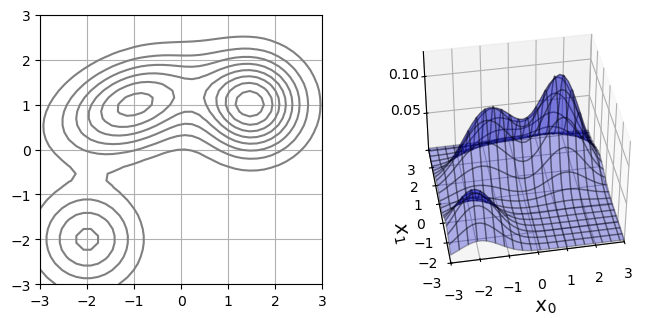

In [42]:
# リスト 9-2-(7)
# テスト ----------
pi = np.array([0.2, 0.4, 0.4]) #混合係数:各ガウス分布の大きさの比率を表す
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]]) # mu:中心ベクトル
sigma = np.array([      # sigma:分散行列
    [[0.5, 0], [0, 0.5]],
    [[1, 0.25], [0.25, 0.5]],
    [[0.5, 0], [0, 0.5]],
])
plt.figure(figsize=(8, 3.5))
# 等高線表示
plt.subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid()
# サーフェス表示
ax = plt.subplot(1, 2, 2, projection="3d")
show3d_mixgauss(ax, pi, mu, sigma)
ax.set_zticks([0.05, 0.10])
ax.set_xlabel("$x_0$", fontsize=14)
ax.set_ylabel("$x_1$", fontsize=14)
ax.view_init(40, -100)
plt.xlim(X0_min, X0_max)
plt.ylim(X1_min, X1_max)
plt.show()

### 9.3.3 EMアルゴリズムの概要

### 9.3.4 Step 0: 変数の準備と初期化

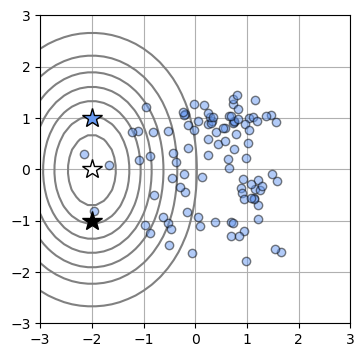

In [44]:
# リスト 9-2-(8)
# パラメータの図示関数 ----------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    cols = np.array([  # 各クラスの描画色(RGB形式)
        [0.4, 0.6, 0.95],
        [1, 1, 1],
        [0, 0, 0],
    ])
    N = x.shape[0] #行数
    K = len(pi) #pi:混合係数:各ガウス分布の大きさの比率を表す
    show_contour_mixgauss(pi, mu, sigma) #混合ガウスの等高線を表示
    # データ点の描画
    for n in range(N): # (ex) 0-n-99
        col = (  # プロットの色をgammaで混合し作成 
            gamma[n, 0] * cols[0]
          + gamma[n, 1] * cols[1]
          + gamma[n, 2] * cols[2]
        )
        plt.plot(
            x[n, 0], x[n, 1], color=col,
            marker="o", markeredgecolor="black",
            markersize=6, alpha=0.5,
        )
    # 中心ベクトルの描画
    for k in range(K): #(ex)0-k-2
        plt.plot(
            mu[k, 0], mu[k, 1], color=cols[k],
            marker="*", markeredgecolor="black",
            markersize=15, markeredgewidth=1,
        )
    plt.grid()

# メイン ----------
N = X.shape[0]  # データ数 100
# パラメータの初期化
Pi = np.array([0.33, 0.33, 0.34]) #混合係数:各ガウス分布の大きさの比率を表す
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # mu:中心ベクトル
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]) # sigma:分散行列
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))] #プロットの色を決めるために使用
# グラフ描画
plt.figure(figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.5 Step 1 (E Step): $\gamma$の更新

In [52]:
# リスト 9-2-(9)
# gamma を更新する (E Step) ----------
def e_step_mixgauss(x, pi, mu, sigma):
    N = x.shape[0] #行数
    K = len(pi) #pi:混合係数:各ガウス分布の大きさの比率を表す
    y = np.zeros((N, K)) #(ex)100行3列の0
    # ガウス関数の値の計算
    for k in range(K): #0-k-2
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :])
    # 式9-16で、負担率gammaを計算
    gamma = np.zeros((N, K)) #100行3列の0
    for n in range(N): #0-n-99
        a = np.zeros(K) #要素数3
        for k in range(K): # 0-k-2
            a[k] = pi[k] * y[n, k]
        gamma[n, :] = a / np.sum(a)
    return gamma

# メイン ----------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
Gamma

array([[0.53290794, 0.36981839, 0.09727367],
       [0.05170748, 0.29787695, 0.65041557],
       [0.35723698, 0.43863061, 0.20413241],
       [0.55078604, 0.36001926, 0.0891947 ],
       [0.49501817, 0.38907383, 0.115908  ],
       [0.53874423, 0.36666816, 0.09458761],
       [0.21934825, 0.44242263, 0.33822912],
       [0.05587918, 0.30657997, 0.63754084],
       [0.2111526 , 0.4405145 , 0.3483329 ],
       [0.23266015, 0.44489255, 0.3224473 ],
       [0.32082481, 0.44510989, 0.2340653 ],
       [0.4883838 , 0.39222372, 0.11939248],
       [0.04721561, 0.28781224, 0.66497215],
       [0.06641778, 0.32623198, 0.60735024],
       [0.51723484, 0.37803888, 0.10472628],
       [0.27715987, 0.44816594, 0.27467419],
       [0.0736976 , 0.3381663 , 0.5881361 ],
       [0.51583686, 0.37875489, 0.10540825],
       [0.5747406 , 0.34621259, 0.07904681],
       [0.54159832, 0.36511032, 0.09329136],
       [0.0729414 , 0.33698157, 0.59007704],
       [0.64638501, 0.30062179, 0.0529932 ],
       [0.

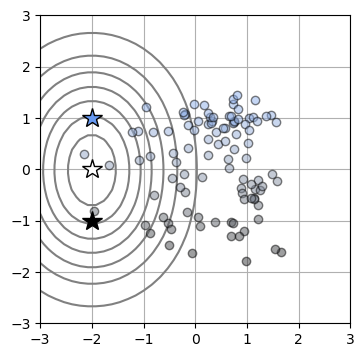

In [54]:
# リスト 9-2-(10)
# パラメータ表示 ----------
plt.figure(figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.6 Step 2(M Step): $\pi$, $\mu$, $\Sigma$の更新

In [56]:
# リスト 9-2-(11)
# Pi、Mu、Sigma を更新する (M step) ----------
def m_step_mixgauss(x, gamma):
    N, D = x.shape #100行2列
    K = gamma.shape[1] #gammaの列数 , (ex)K=3
    # 式9-17で、N_kを計算
    N_k = np.sum(gamma, axis=0) #負担率の和を縦の合計に計算
    # 式9-18で、piを計算
    pi = N_k / N #全データで負担率の和を割る
    # 式9-19で、muを計算
    mu = np.zeros((K, D)) #mu(中心ベクトル): 3行3列の0
    for k in range(K): # (ex) 0-k-2
        for d in range(D): # (ex) 0-d-1
            mu[k, d] = gamma[:, k] @ x[:, d] / N_k[k]
    # 式9-20で、sigmaを計算
    sigma = np.zeros((K, D, D)) # 3つのクラスターで2行2列 , sigma:分散行列
    for k in range(K): # 0-k-2
        sigma_k = np.zeros((D, D)) # sigma:分散行列, 2行2列
        for n in range(N): # 0-n-99
            x_mu = x[n, :] - mu[k, :]  # x - mu 
            x_mu = x_mu.reshape(2, 1)  # 縦ベクトルに直す(2行1列)
            sigma_k = sigma_k + gamma[n, k] * x_mu @ x_mu.T  #gamma:負担率,外積:縦ベクトル*横ベクトル, sigma_k:2行2列
        sigma[k, :, :] = sigma_k / N_k[k] # k:クラスター番号
    return pi, mu, sigma

# メイン ----------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

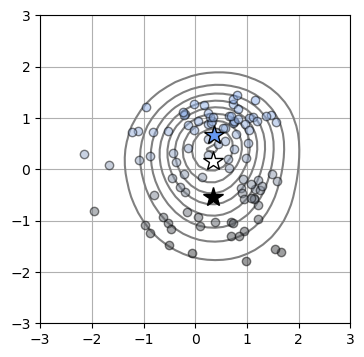

In [60]:
# リスト 9-2-(12)
# パラメータ表示 ----------
plt.figure(figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

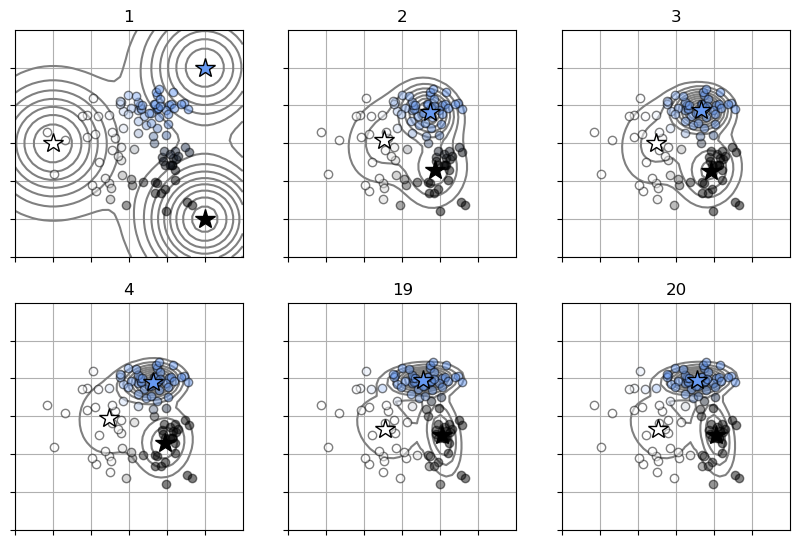

In [62]:
# リスト 9-2-(13)
# パラメータの初期化 --------
Pi = np.array([0.3, 0.3, 0.4]) #混合係数:各ガウス分布の大きさの比率を表す
Mu = np.array([[2, 2], [-2, 0], [2, -2]]) #中心ベクトル
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]) # sigma:分散行列
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
max_it = 20  # 繰り返しの回数

# メイン --------
plt.figure(figsize=(10, 6.5))
i_subplot = 1
for it in range(0, max_it): #0-it-19
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)  # E-step(負担率の更新) 1つのデータに関してガウス関数の値と混合係数をかけたもの(A)をクラス全体の総和(Asum)で割る
    if it < 4 or it > 17:                      # パラメータの描画
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma) #データ・中心ベクトルのプロットとガウス分布の等高線を描く
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X0_min, X0_max), "")
        plt.yticks(range(X1_min, X1_max), "")
        i_subplot = i_subplot + 1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)  # M-step　混合係数、中心ベクトル、分散行列を更新
plt.show()

### 9.3.7 尤度

In [64]:
# リスト 9-2-(14)
# 混合ガウスの誤差関数 ----------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD (ex) 100*2
    # pi: Kx1 (ex) 3*1
    # mu: KxD (ex) 3*2
    # sigma: KxDxD (ex) 3*2*2
    # output err: NxK # 100*3
    N = x.shape[0] #行数 (ex) 100行
    K = len(pi) #混合係数:各ガウス分布の大きさの比率を表す
    # ガウス関数の値を計算
    y = np.zeros((N, K)) #(ex)100行3列の0
    for k in range(K): #0-k-2
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :])
    # 式9-22で、対数尤度の計算
    lh = 0
    for n in range(N): # 0-n-99
        sum_pi_g = 0
        for k in range(K): # 0-k-2
            sum_pi_g = sum_pi_g + pi[k] * y[n, k] #混合係数＊ガウス関数の値をクラスごとに計算
        lh = lh + np.log(sum_pi_g)
    # 誤差関数に変換
    err = -lh  # 確率が0~1なので通常対数尤度lhはマイナスになるので-lhにして正の値を取るように調整している
    return err

Err = [426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


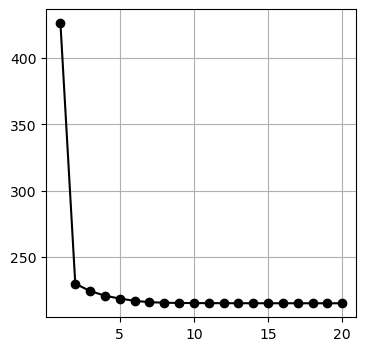

In [68]:
# リスト 9-2-(15)
# パラメータの初期化 ----------
Pi = np.array([0.3, 0.3, 0.4]) #混合係数:各ガウス分布の大きさの比率を表す
Mu = np.array([[2, 2], [-2, 0], [2, -2]]) #中心ベクトル
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]) #分散行列
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))] #100行3列, 負担率:データ１つに注目し、そのデータがクラスkに属している割合

# 誤差関数の計算 ----------
max_it = 20
it = 0
Err = np.zeros(max_it)
for it in range(0, max_it): # 0-it-19
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)  # E-step(負担率の更新) 1つのデータに関してガウス関数の値と混合係数をかけたもの(A)をクラス全体の総和(Asum)で割る
    Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)   # 誤差関数の値を計算
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)  # M-step 混合係数、中心ベクトル、分散行列を更新
# 結果表示
print('Err =', np.round(Err, 2))

# グラフ描画 ----------
plt.figure(figsize=(4, 4))
plt.plot(np.arange(max_it) + 1, Err, "black", linestyle="-", marker="o")
plt.grid()
plt.show()